<a href="https://colab.research.google.com/github/Natanael29/FSI_Practica2_NeuralNetwork/blob/main/PR2_REDES_NEURONALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 2 de Fundamentos de los Sistemas Inteligentes: Redes Neuronales

##Descripción del proyecto

  Como sabemos, nos encontramos atravesando una pandemia mundial causada por la enfermedad infecciosa llamada COVID-19. Se trata de una enfermedad que produce síntomas similares a los de la gripe, como la fiebre, tos, dificultad respiratoria, dolor muscular y fatiga. En algunos casos más graves puede llegar a producir neumonía, por lo que en ocasiones, puede resultar difícil diferenciar entre ellas. En nuestro proyecto hemos decidido entrenar una red neuronal que pueda categorizar, a través de imágenes de radiografías de pulmones, si se trata de neumonía, COVID-19, o si por el contrario se trata de unos pulmones sanos.

##Especificaciones

  Para poder realizar la práctica, vamos a utilizar Keras, que es una biblioteca de Redes Neuronales de código abierto escrita en Python. Sus características más relevantes se centran en ser amigable para el usuario, modular y extensible.
  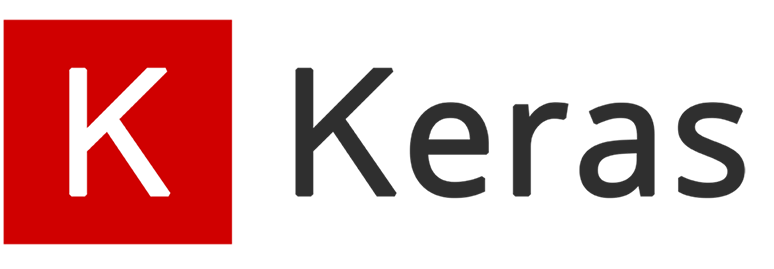


#1. Red Neuronal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Data source

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
import keras
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 32
num_classes = 3

train_data_dir = '/content/drive/MyDrive/dataset/Covid19_TRAIN/train'
validation_data_dir = '/content/drive/MyDrive/dataset/COVID-19_TEST/test'

##Data augmentation

Como sabemos, el data augmentation consiste en aplicar una serie de ligeras modificaciones a las imágenes que forman el dataset con el que vamos a trabajar para aumentar el conjunto de imágenes, como por ejemplo, invertir la imagen ampliarla o incluso rotarla. Como resultado, tendremos más imágenes que ayudarán al clasificador a discernir entre los distintos casos que se presenten, que en el nuestro se trata de diferenciar entre COVID-19, neumonía o pulmones sanos.

El data augmentation se lleva a cabo definiendo una serie de parámetros en la inicialización de la clase ImageDataGenerator. En nuestro caso, nuestra inicialización es la siguiente:


In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(500, 500),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(500, 500),
        batch_size=batch_size,
        class_mode='categorical')

##Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print("\n-----------------------> Resumen del modelo <---------------------\n")
model.summary()


##Training

In [ ]:
epochs = 50

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

history = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [es]
)

##Plot

In [ ]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.title('Entrenamiento Red Neuronal')
plt.xlabel('Épocas')
plt.legend(loc="lower right")
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title('Entrenamiento Red Neuronal(Pérdida)')
plt.xlabel('Épocas')
plt.legend(loc="lower right")
plt.show()

##Saving

In [ ]:
model.save("mimodelo.h5")

#2. Transfer Learning


##Model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping


# DATA SOURCE --------------------------------------------------

batch_size = 20

train_data_dir = '/content/drive/MyDrive/dataset/Covid19_TRAIN/train'
validation_data_dir = '/content/drive/MyDrive/dataset/COVID-19_TEST/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(300, 300),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(300, 300),
        batch_size=batch_size,
        class_mode='categorical')


# MODEL --------------------------------------------------

#model = VGG16(include_top=False, input_shape=(300, 300, 3))
#flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(128, activation='relu')(flat1)
#output = Dense(3, activation='softmax')(class1)
# define new model
#model = Model(inputs=model.inputs, outputs=output)
#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
top_model = Flatten()(conv_base.output)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(3, activation='softmax')(top_model)
model = Model(inputs=conv_base.inputs, outputs=output_layer)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print("\n-----------------------> Resumen del modelo <---------------------\n")
model.summary()

##Training


In [ ]:
# TRAINING --------------------------------------------------

epochs = 50

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

history = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
13/13 [==============================] - 547s 42s/step - loss: 1.2115 - accuracy: 0.3246 - val_loss: 1.0494 - val_accuracy: 0.5606
Epoch 2/50
13/13 [==============================] - 543s 43s/step - loss: 1.1957 - accuracy: 0.3428 - val_loss: 0.9845 - val_accuracy: 0.6515
Epoch 3/50
13/13 [==============================] - 542s 42s/step - loss: 0.9981 - accuracy: 0.5519 - val_loss: 0.9203 - val_accuracy: 0.7273
Epoch 4/50
13/13 [==============================] - 541s 42s/step - loss: 1.0065 - accuracy: 0.4813 - val_loss: 0.8638 - val_accuracy: 0.7273
Epoch 5/50
13/13 [==============================] - 543s 42s/step - loss: 0.8954 - accuracy: 0.5893 - val_loss: 0.8087 - val_accuracy: 0.7424
Epoch 6/50
13/13 [==============================] - 542s 42s/step - loss: 0.8589 - accuracy: 0.5956 - val_loss: 0.7532 - val_accuracy: 0.7879
Epoch 7/50
13/13 [==============================] - 540s 42s/step - loss: 0.7967 - accuracy: 0.6618 - val_loss: 0.7032 - val_accuracy: 0.8333
Epoch 

##Plot

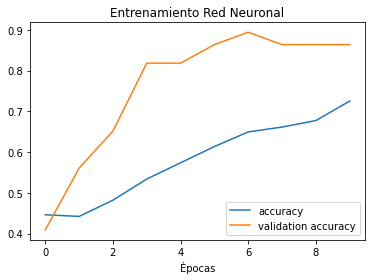

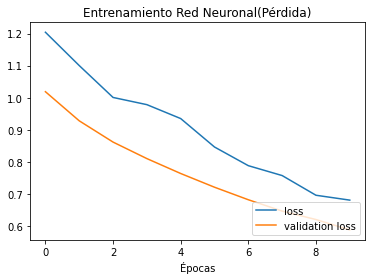

In [15]:
# PLOTTING --------------------------------------------------
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.title('Entrenamiento Red Neuronal')
plt.xlabel('Épocas')
plt.legend(loc="lower right")
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title('Entrenamiento Red Neuronal(Pérdida)')
plt.xlabel('Épocas')
plt.legend(loc="lower right")
plt.show()

##Save

In [ ]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#3. Informe

##Distintas configuraciones de hiperparámetros

### - Configuración base con tamaño de imagen 400 x 400


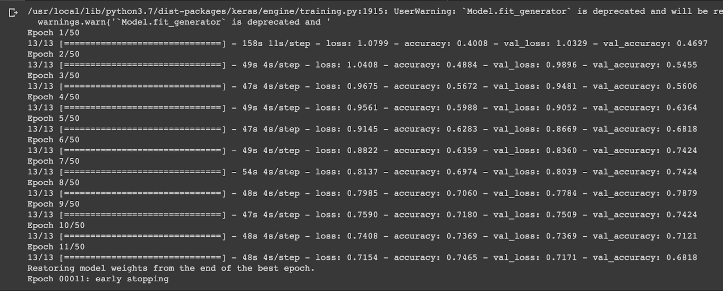
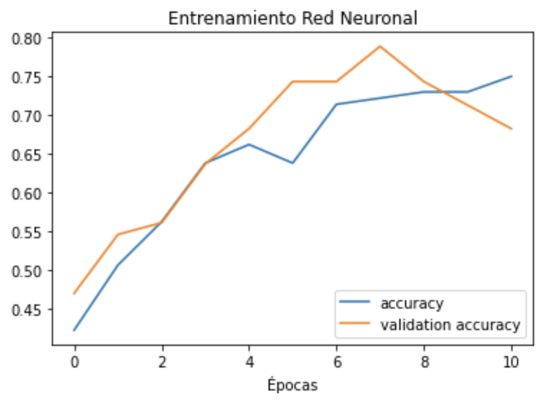

### - Configuración con tamaño de kernel 5 x 5
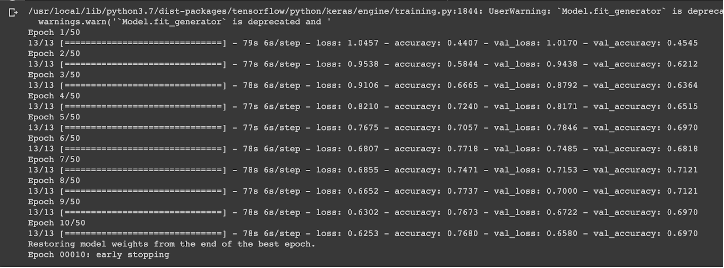
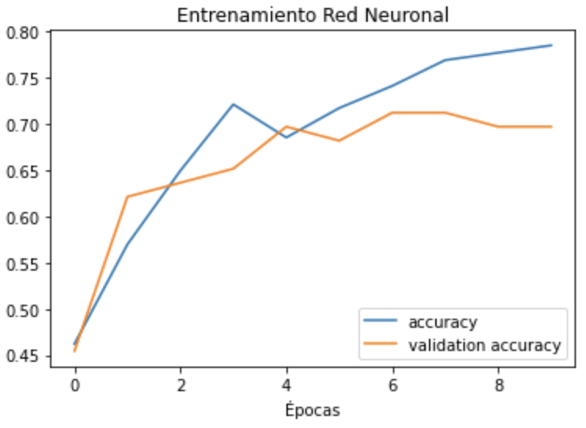

### - Configuración con método de optimización SGD
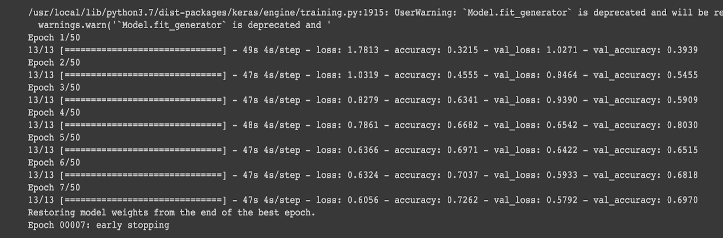
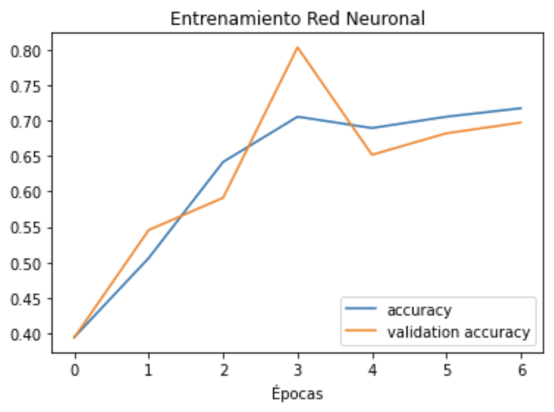

##Función de pérdida Categorical Cross Entropy
Las funciones de pérdida se utilizan para optimizar el modelo durante el entrenamiento. Normalmente, el objetivo es minimizar esta función, puesto que, cuanto menor sea la pérdida, mejor será el modelo. La pérdida de entropía cruzada (cross entropy) es una función de costo muy importante que se utiliza para optimizar los modelos de clasificación. La comprensión de dicha función pasa por el entendimiento de la función de activación Softmax. Para ello, vamos a explicarlo mediante un ejemplo:
Supongamos que queremos clasificar 4 clases en la que una imagen se clasifica como un perro, gato, caballo o guepardo (Imagen inferior).

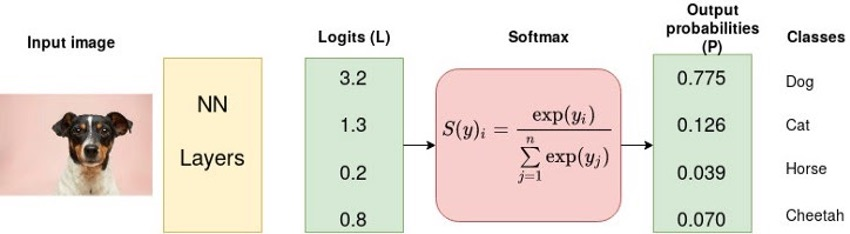

En esta figura, Softmax convierte logits en probabilidades, y el objetivo de la entropía cruzada es tomar las probabilidades de salida y medir la distancia desde los valores de verdad (Imagen inferior).

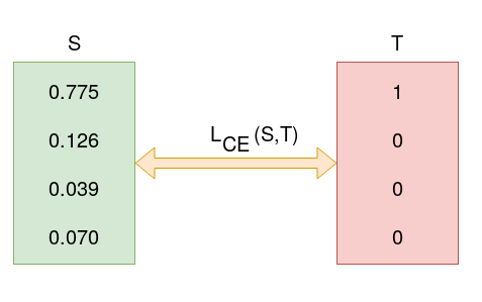

Para este ejemplo, la salida deseada es [1, 0, 0, 0] para la clase perro pero las salidas del modelo son [0.775, 0.126, 0.039, 0.070]. El objetivo es hacer que la salida del modelo sea lo más cercana posible a la salida deseada. Durante el entrenamiento del modelo, los pesos del modelo se ajustan iterativamente en consecuencia con el objetivo de minimizar la pérdida de entropía cruzada. El proceso de ajustar los pesos es lo que define el entrenamiento del modelo y como el modelo sigue entrenando la pérdida se minimiza, por lo que decimos que el modelo está aprendiendo.